visualization(line chart)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def process_csv(file_path):
    df = pd.read_csv(file_path)
    df['Year'] = pd.to_datetime(df['Year'], format='%Y')
    
    # Select only 'Sheltered and Unsheltered Count' data
    df_filtered = df[df['Count Types'] == 'Sheltered and Unsheltered Count']
    
    # Group by year and homelessness type
    grouped = df_filtered.pivot_table(values='Count', index='Year', 
                                      columns='Homelessness.Type', aggfunc='sum')
    
    return grouped

def create_line_chart(data):
    plt.figure(figsize=(12, 8))
    
    # Use Seaborn to create a line chart
    sns.set_style("whitegrid")
    sns.set_palette("husl")

    for column in data.columns:
        sns.lineplot(x=data.index, y=data[column], label=column, marker='o')
    
    plt.title('Trends in Homeless Population Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Homeless People', fontsize=12)
    plt.legend(title='Homelessness Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set x-axis ticks to years
    years = data.index.year
    plt.xticks(data.index, years, rotation=45)
    
    # Add value labels to each data point
    for column in data.columns:
        for x, y in zip(data.index, data[column]):
            if pd.notna(y):
                plt.text(x, y, f'{y:.0f}', ha='center', va='bottom')

    # Set y-axis tick format
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    plt.tight_layout()
    plt.savefig('homeless_count_line_chart.png', dpi=300, bbox_inches='tight')
    print("Line chart has been saved as 'homeless_count_line_chart.png'")

def main():
    file_path = r"C:\Users\86133\Desktop\final_dataset.csv"
    data = process_csv(file_path)
    create_line_chart(data)

if __name__ == "__main__":
    main()

visualization for different types of homelessness 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

file_path = r'C:\Users\86133\Desktop\final_dataset.csv' 
data = pd.read_csv(file_path)

time_series_data = data.groupby(['Year', 'Homelessness.Type'])['Count'].sum().unstack()

filtered_time_series_data = time_series_data.drop(columns=['Overall.Homeless'])

rename_columns = {
    'Sheltered.Total.Homeless': 'Sheltered',
    'Unsheltered.Homeless': 'Unsheltered',
    'Overall.Homeless.Individuals': 'Homeless.Individuals',
    'Overall.Homeless.People.in.Families': 'Homeless.Families'
}
filtered_time_series_data = filtered_time_series_data.rename(columns=rename_columns)

plt.figure(figsize=(12, 8))

cmap = get_cmap('Set2')

for idx, column in enumerate(filtered_time_series_data.columns):
    plt.plot(
        filtered_time_series_data.index, 
        filtered_time_series_data[column], 
        marker='o', 
        linewidth=2.5,  
        markersize=8, 
        color=cmap(idx), 
        label=column
    )

plt.title('Homelessness Count Over Time by Type (Excluding Overall.Homeless)', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Homelessness Count', fontsize=14)

plt.legend(title='Homelessness Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()


plt.show()


draw plot of Rental vacancy rate (Available in ACS Table b25004)

In [ ]:
import requests
import pandas as pd
from census import Census
import matplotlib.pyplot as plt
import seaborn as sns


API_KEY = "e63b9fadedce61ed9b27cf5cdc426d42fb2dc149"
c = Census(API_KEY)

years = range(2010, 2023)  


state_codes = {
    "Alabama": "01",
    "Alaska": "02",
    "Arizona": "04",
    "Arkansas": "05",
    "California": "06",
    "Colorado": "08",
    "Connecticut": "09",
    "Delaware": "10",
    "District of Columbia": "11",
    "Florida": "12",
    "Georgia": "13",
    "Hawaii": "15",
    "Idaho": "16",
    "Illinois": "17",
    "Indiana": "18",
    "Iowa": "19",
    "Kansas": "20",
    "Kentucky": "21",
    "Louisiana": "22",
    "Maine": "23",
    "Maryland": "24",
    "Massachusetts": "25",
    "Michigan": "26",
    "Minnesota": "27",
    "Mississippi": "28",
    "Missouri": "29",
    "Montana": "30",
    "Nebraska": "31",
    "Nevada": "32",
    "New Hampshire": "33",
    "New Jersey": "34",
    "New Mexico": "35",
    "New York": "36",
    "North Carolina": "37",
    "North Dakota": "38",
    "Ohio": "39",
    "Oklahoma": "40",
    "Oregon": "41",
    "Pennsylvania": "42",
    "Rhode Island": "44",
    "South Carolina": "45",
    "South Dakota": "46",
    "Tennessee": "47",
    "Texas": "48",
    "Utah": "49",
    "Vermont": "50",
    "Virginia": "51",
    "Washington": "53",
    "West Virginia": "54",
    "Wisconsin": "55",
    "Wyoming": "56"
}


variables = {
    "B25004_003E": "For Rent (Rental Vacancy Rate)",
    "B25008_003E": "Renter-Occupied Units",
    "B25008_001E": "Total Occupied Housing Units"
}

all_data = []
for state_name, state_fips in state_codes.items():
    for year in years:
        try:
            year_data = c.acs5.state_county_tract(
                fields=list(variables.keys()), 
                state_fips=state_fips, 
                county_fips="*", 
                tract="*", 
                year=year
            )
            
            df_year = pd.DataFrame(year_data)
            df_year['year'] = year
            df_year['state'] = state_name  
            
  
            df_year.rename(columns=variables, inplace=True)
            
            df_year['Percent_Renter_Households'] = (
                df_year['Renter-Occupied Units'].astype(float) / 
                df_year['Total Occupied Housing Units'].astype(float)) * 100
            
            all_data.append(df_year)
        
        except Exception as e:
            print(f"Error fetching data for {state_name} in {year}: {e}")

merged_data = pd.concat(all_data, ignore_index=True)

merged_data['Rental Vacancy Rate'] = (
    merged_data['For Rent (Rental Vacancy Rate)'].astype(float) / 
    merged_data['Total Occupied Housing Units'].astype(float)) * 100

print(merged_data.head())

plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='Rental Vacancy Rate', hue='state', data=merged_data)
plt.title('Rental Vacancy Rate (2010-2023)')
plt.xlabel('Year')
plt.ylabel('Rental Vacancy Rate (%)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='Percent_Renter_Households', hue='state', data=merged_data)
plt.title('Percent Renter Households (2010-2023)')
plt.xlabel('Year')
plt.ylabel('Percent Renter Households (%)')
plt.grid(True)
plt.show()

merged_data.to_csv("ACS_data_2010_2023.csv", index=False)


Model--RandomForest

Results for Overall_Homeless_Per_Capita:
  RMSE: 0.0009907034086465655
  R2: 0.7866952950586095
Results for Overall_Homeless_Individuals_Per_Capita:
  RMSE: 0.0007782987015951633
  R2: 0.7802577009261995
Results for Overall_Homeless_People_in_Families_Per_Capita:
  RMSE: 0.0003804617094373637
  R2: 0.8177533352397971
Results for Unsheltered_Homeless_Per_Capita:
  RMSE: 0.0007895180095767498
  R2: 0.7001968176299176
Results for Sheltered_Homeless_Per_Capita:
  RMSE: 0.00048337350943826506
  R2: 0.8798849738992097


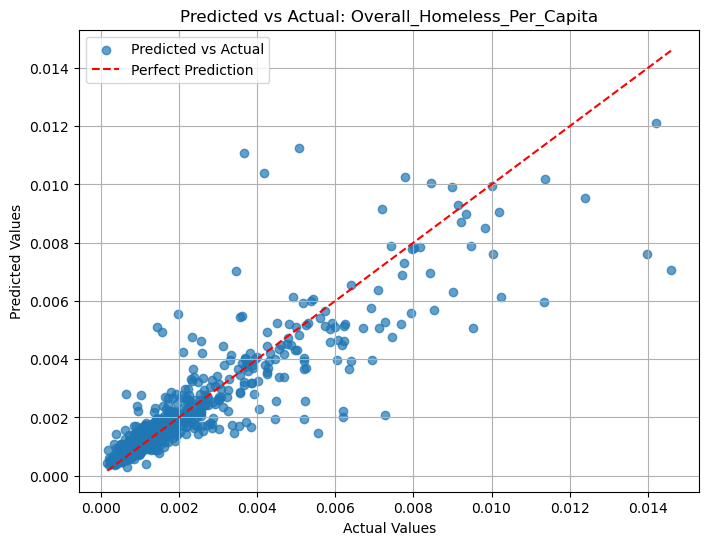

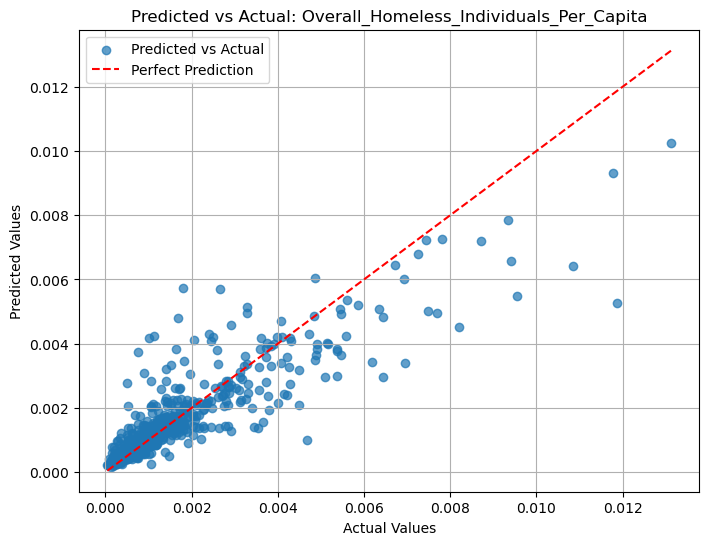

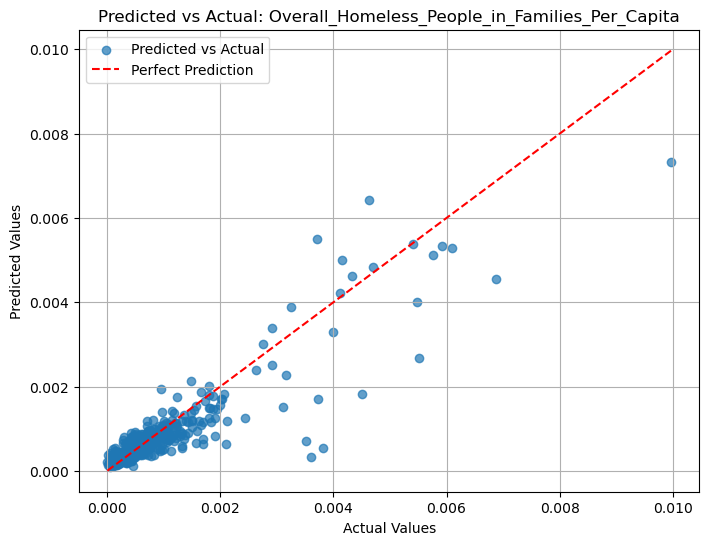

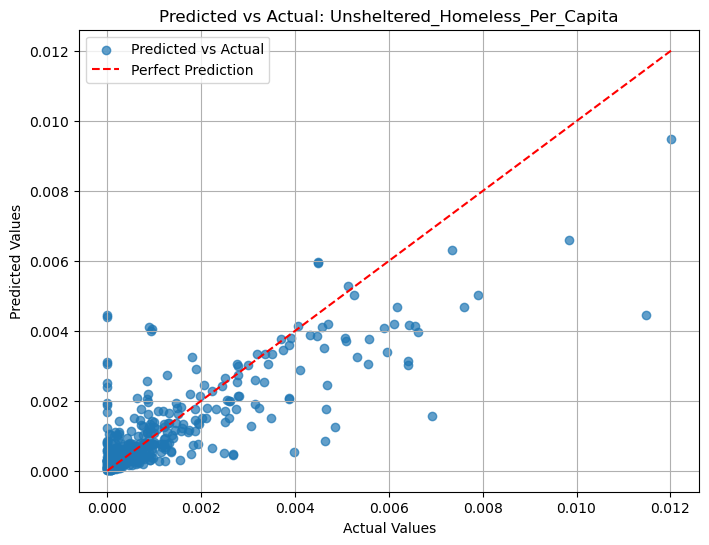

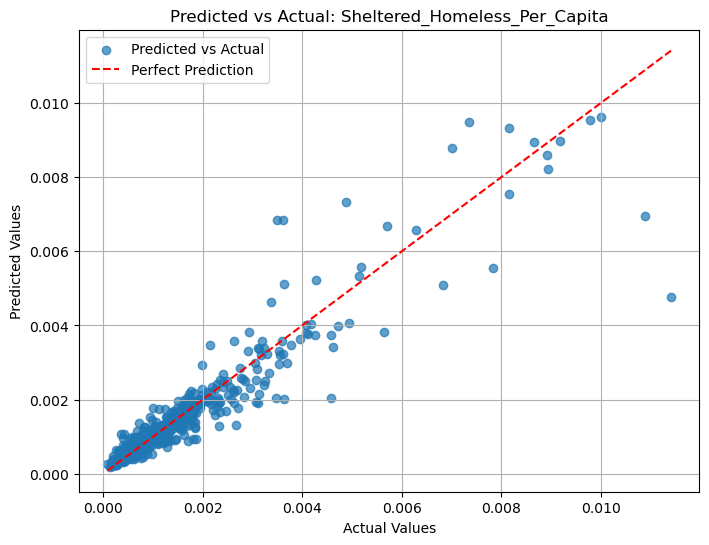

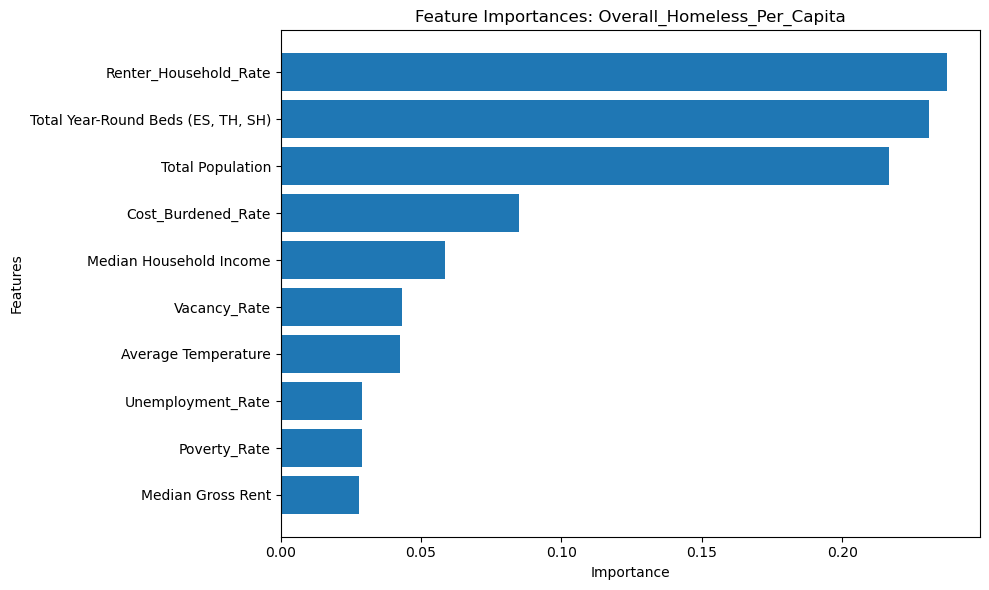

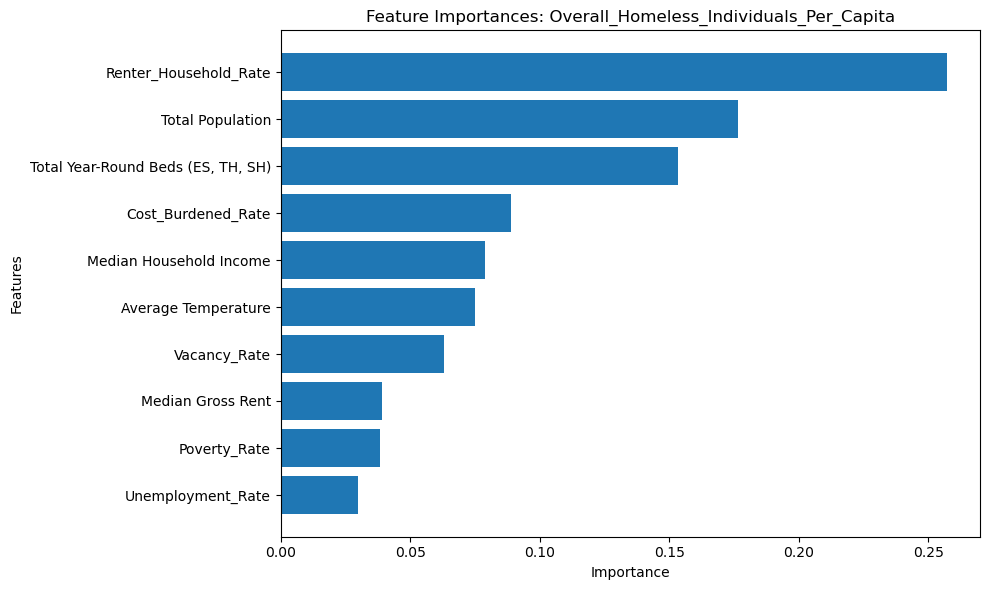

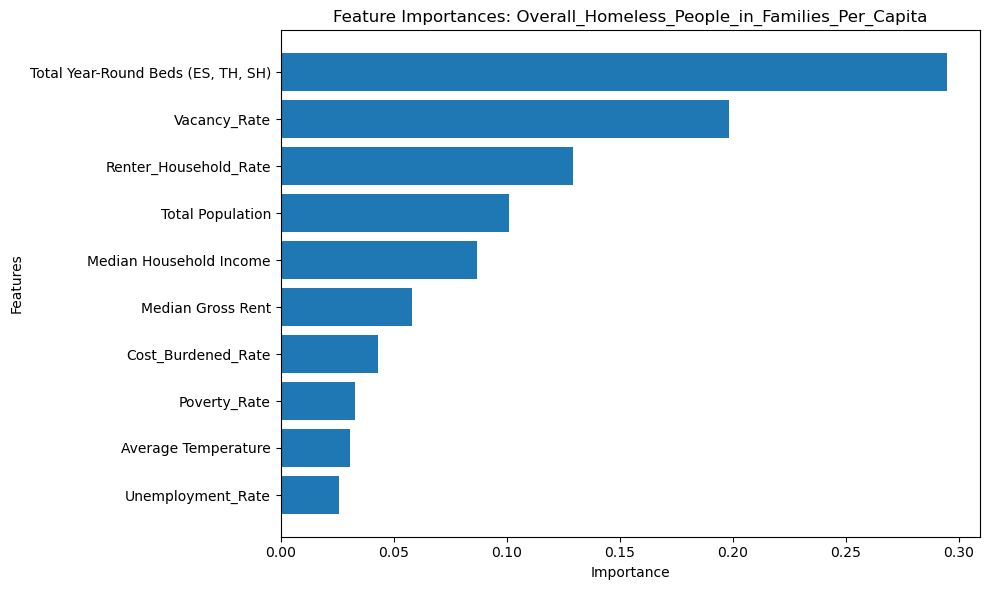

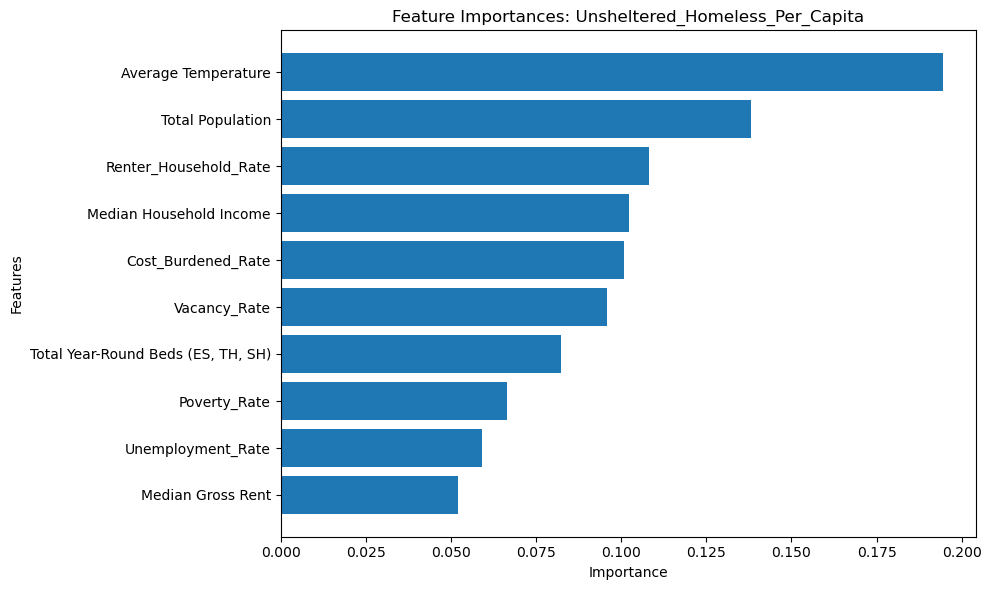

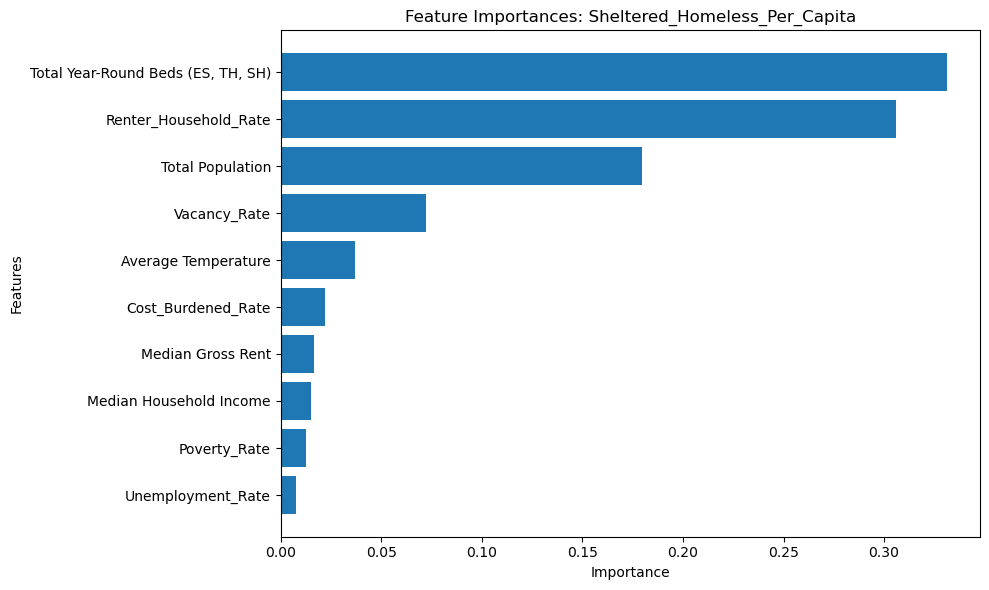

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
file_path = r"C:\\Users\\86133\\Desktop\\Final_estimate_with_per_capita.csv"
data = pd.read_csv(file_path)

# Define predictor and target variables
predictors = [
    "Total Population",
    "Median Gross Rent",
    "Median Household Income",
    "Poverty_Rate",
    "Vacancy_Rate",
    "Renter_Household_Rate",
    "Cost_Burdened_Rate",
    "Unemployment_Rate",
    "Total Year-Round Beds (ES, TH, SH)",
    "Average Temperature"
]

targets = [
    "Overall_Homeless_Per_Capita",
    "Overall_Homeless_Individuals_Per_Capita",
    "Overall_Homeless_People_in_Families_Per_Capita",
    "Unsheltered_Homeless_Per_Capita",
    "Sheltered_Homeless_Per_Capita"
]

# Drop rows with missing values for simplicity
data_cleaned = data.dropna(subset=predictors + targets)

# Split data into features (X) and targets (y)
X = data_cleaned[predictors]
y = data_cleaned[targets]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RandomForest models for each target
models = {}
predictions = {}
results = {}

for target in targets:
    model = RandomForestRegressor(random_state=42, n_estimators=100)
    model.fit(X_train, y_train[target])
    y_pred = model.predict(X_test)
    
    # Store the model and predictions
    models[target] = model
    predictions[target] = y_pred
    
    # Evaluate model performance
    rmse = np.sqrt(mean_squared_error(y_test[target], y_pred))
    r2 = r2_score(y_test[target], y_pred)
    results[target] = {"RMSE": rmse, "R2": r2}

# Print results
for target, metrics in results.items():
    print(f"Results for {target}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")

# Visualize predictions vs. actual values for each target
for target in targets:
    y_actual = y_test[target]
    y_pred = predictions[target]

    # Scatter plot
    plt.figure(figsize=(8, 6))  # Adjusted for vertical orientation
    plt.scatter(y_actual, y_pred, alpha=0.7, label='Predicted vs Actual')
    
    # Line of perfect prediction
    line = np.linspace(min(y_actual.min(), y_pred.min()), max(y_actual.max(), y_pred.max()), 100)
    plt.plot(line, line, color='red', linestyle='--', label='Perfect Prediction')

    plt.title(f"Predicted vs Actual: {target}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize feature importances for each target
for target in targets:
    model = models[target]
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))  # Adjusted for vertical orientation
    plt.barh(range(X.shape[1]), importances[indices], align="center")
    plt.yticks(range(X.shape[1]), X.columns[indices])
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.title(f"Feature Importances: {target}")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()


Loading data...
Processing data...

Starting model training...

Target: Overall_Homeless_Per_Capita

Performance:
Train R2: 0.4748
Test R2: 0.2120
Cross-validation R2: 0.2474 (±0.1522)
RMSE: 0.0272

Target: Overall_Homeless_Individuals_Per_Capita

Performance:
Train R2: 0.4750
Test R2: 0.2680
Cross-validation R2: 0.2530 (±0.1356)
RMSE: 0.0169

Target: Overall_Homeless_People_in_Families_Per_Capita

Performance:
Train R2: 0.4740
Test R2: 0.2668
Cross-validation R2: 0.2513 (±0.1714)
RMSE: 0.0094

Target: Unsheltered_Homeless_Per_Capita

Performance:
Train R2: 0.4869
Test R2: 0.2496
Cross-validation R2: 0.2522 (±0.1536)
RMSE: 0.0086

Target: Sheltered_Homeless_Per_Capita

Performance:
Train R2: 0.4846
Test R2: 0.2183
Cross-validation R2: 0.2334 (±0.1622)
RMSE: 0.0185

Generating feature importance plots...
